# **(NN CNN and TABNET) Anomaly Detection in BITCOIN DATASET**

Connect Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Necessary Modules

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import gc
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, balanced_accuracy_score, classification_report
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
#ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

Load Data

In [ ]:
file_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/DG_out.csv'
df = pd.read_csv(file_path, sep=',')
df.head()

,tx_hash,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,is_malicious,out_and_tx_malicious,all_malicious
0,0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...,0,1,0.0,50.0,50.0,0.0,50.0,0,0,0,0,0
1,f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...,1,2,50.0,50.0,100.0,50.0,25.0,0,0,0,0,0
2,ea44e97271691990157559d0bdd9959e02790c34db6c00...,1,1,10.0,10.0,20.0,10.0,10.0,0,0,0,0,0
3,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,1,1,40.0,30.0,70.0,40.0,30.0,0,0,0,0,0
4,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,1,2,30.0,30.0,60.0,30.0,15.0,0,0,0,0,0


In [ ]:
df.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1, inplace=True)
df.columns

Index(['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc',
       'mean_in_btc', 'mean_out_btc', 'out_and_tx_malicious'],
      dtype='object')

In [ ]:
df.describe()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,out_and_tx_malicious
count,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07
mean,2.148699e+00,2.148699e+00,5.484150e+01,5.484150e+01,1.096830e+02,4.923980e+01,2.877087e+01,3.570468e-06
std,7.421447e+00,4.512048e+00,1.303303e+03,1.301473e+03,2.602527e+03,9.729210e+02,7.125567e+02,1.889565e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2.000000e+00,1.000000e-01,9.950000e-02,2.058720e-01,6.400000e-02,5.025776e-02,0.000000e+00
50%,1.000000e+00,2.000000e+00,9.325000e-01,9.590000e-01,1.964759e+00,5.350261e-01,4.900000e-01,0.000000e+00
75%,2.000000e+00,2.000000e+00,8.591912e+00,9.063657e+00,1.840000e+01,5.614287e+00,4.519481e+00,0.000000e+00
max,1.932000e+03,1.322000e+03,5.500000e+05,5.000207e+05,1.050000e+06,4.992596e+05,5.000000e+05,1.000000e+00


No Frauds 99.99964 % of the dataset
Frauds 0.00036 % of the dataset


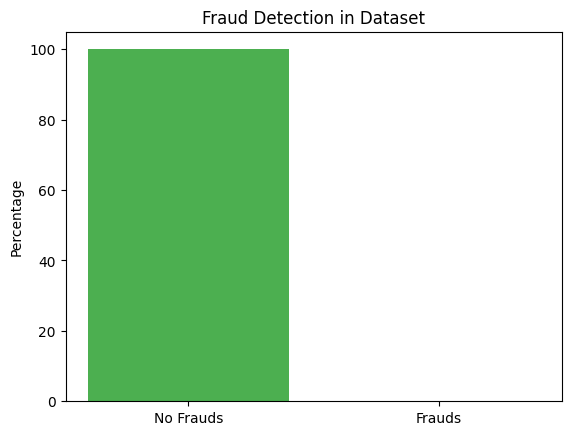

In [ ]:
fraud_counts = df['out_and_tx_malicious'].value_counts().tolist()
labels = ['No Frauds', 'Frauds']
total = len(df)
percentages = [count / total * 100 for count in fraud_counts]
print('No Frauds', round(percentages[0], 5), '% of the dataset')
print('Frauds', round(percentages[1], 5), '% of the dataset')

fig, ax = plt.subplots()
ax.bar(labels, percentages, color=['#4CAF50', '#F44336'])
ax.set_title('Fraud Detection in Dataset')
ax.set_ylabel('Percentage')
plt.show()

Feature Scaling using Log Transformation and RobustScaler.                 
Split data into training and testing sets

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Class distribution after SMOTE: out_and_tx_malicious
0    24198429
1    24198429
Name: count, dtype: int64
Class distribution after SMOTE: out_and_tx_malicious
0    24198429
1    24198429
Name: count, dtype: int64


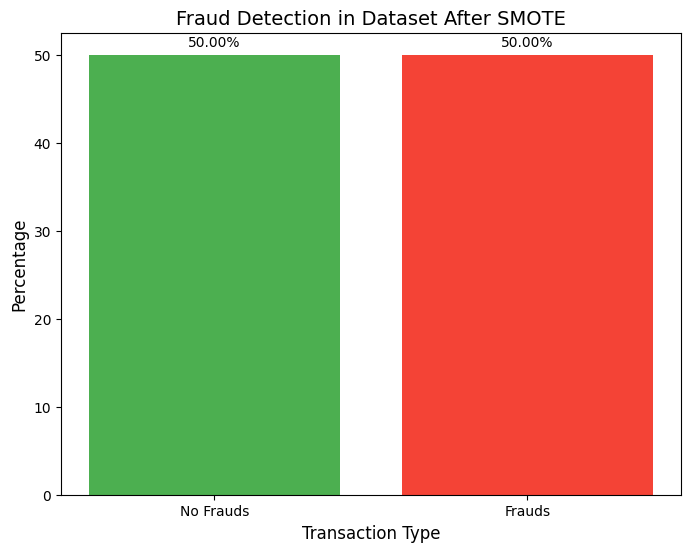

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

# Assuming 'df' is your DataFrame
# Split data into features and labels
X = df.drop('out_and_tx_malicious', axis=1)
y = df['out_and_tx_malicious']

# Log transformation of relevant columns
df['indegree'] = np.log1p(df['indegree'])
df['outdegree'] = np.log1p(df['outdegree'])
df['in_btc'] = np.log1p(df['in_btc'])
df['out_btc'] = np.log1p(df['out_btc'])
df['total_btc'] = np.log1p(df['total_btc'])
df['mean_in_btc'] = np.log1p(df['mean_in_btc'])
df['mean_out_btc'] = np.log1p(df['mean_out_btc'])

# Scale the data
scaler = RobustScaler()
df[['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']] = scaler.fit_transform(
    df[['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']]
)

# Split data after preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set sampling_strategy to 1.0 for a balanced dataset
smote = SMOTE(sampling_strategy=1.0, random_state=42, n_jobs=-1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution
print(f"Class distribution after SMOTE: {y_resampled.value_counts()}")

# Print the class distribution after resampling
print(f"Class distribution after SMOTE: {y_resampled.value_counts()}")

# Class distribution after SMOTE
class_distribution = y_resampled.value_counts()
labels = ['No Frauds', 'Frauds']

# Correct percentages calculation
percentages = [(count / len(y_resampled)) * 100 for count in class_distribution]

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, percentages, color=['#4CAF50', '#F44336'])
ax.set_title('Fraud Detection in Dataset After SMOTE', fontsize=14)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_xlabel('Transaction Type', fontsize=12)

# Display the values on top of the bars
for i, percentage in enumerate(percentages):
    ax.text(i, percentage + 1, f'{percentage:.2f}%', ha='center', fontsize=10)

# Show the plot
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import gc
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, balanced_accuracy_score, classification_report
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
#ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)
file_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/DG_out.csv'
df = pd.read_csv(file_path, sep=',')
df.head()
df.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1, inplace=True)
df.columns
df['indegree'] = np.log1p(df['indegree'])
df['outdegree'] = np.log1p(df['outdegree'])
df['in_btc'] = np.log1p(df['in_btc'])
df['out_btc'] = np.log1p(df['out_btc'])
df['total_btc'] = np.log1p(df['total_btc'])
df['mean_in_btc'] = np.log1p(df['mean_in_btc'])
df['mean_out_btc'] = np.log1p(df['mean_out_btc'])
scaler = RobustScaler()
df['indegree'] = scaler.fit_transform(df['indegree'].values.reshape(-1, 1))
df['outdegree'] = scaler.fit_transform(df['outdegree'].values.reshape(-1, 1))
df['in_btc'] = scaler.fit_transform(df['in_btc'].values.reshape(-1, 1))
df['out_btc'] = scaler.fit_transform(df['out_btc'].values.reshape(-1, 1))
df['total_btc'] = scaler.fit_transform(df['total_btc'].values.reshape(-1, 1))
df['mean_in_btc'] = scaler.fit_transform(df['mean_in_btc'].values.reshape(-1, 1))
df['mean_out_btc'] = scaler.fit_transform(df['mean_out_btc'].values.reshape(-1, 1))

# Split data into features and labels
X = df.drop('out_and_tx_malicious', axis=1)
y = df['out_and_tx_malicious']
from collections import Counter
print(f"Original class distribution: {Counter(y)}")
minority_class_size = y.value_counts()[1]
majority_class_size = y.value_counts()[0]

# Set sampling_strategy to 1.0 for a balanced dataset
smote = SMOTE(sampling_strategy=1.0, random_state=42, n_jobs=-1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original class distribution: Counter({0: 30248026, 1: 108})


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [ ]:
from imblearn.over_sampling import SMOTE

# Set sampling_strategy to 1.0 for a balanced dataset
smote = SMOTE(sampling_strategy=1.0, random_state=42, n_jobs=-1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution
print(f"Class distribution after SMOTE: {y_resampled.value_counts()}")


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Class distribution after SMOTE: out_and_tx_malicious
0    19360414
1    19360414
Name: count, dtype: int64


NN model

Mounted at /content/drive
Original class distribution: Counter({0: 30248026, 1: 108})


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Class distribution after SMOTE: Counter({0: 24198429, 1: 24198429})
Class distribution after undersampling: Counter({0: 24198429, 1: 24198429})
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8000/8000 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8348 - loss: 0.3612 - val_accuracy: 0.8860 - val_loss: 0.2677
Epoch 2/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8803 - loss: 0.2830 - val_accuracy: 0.8966 - val_loss: 0.2440
Epoch 3/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8879 - loss: 0.2658 - val_accuracy: 0.8994 - val_loss: 0.2356
Epoch 4/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8929 - loss: 0.2558 - val_accuracy: 0.9064 - val_loss: 0.2251
Epoch 5/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8969 - loss: 0.2486 - val_accuracy: 0.9138 - val_loss: 0.2209
Epoch 6/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8997 - loss: 0.2445 - val_accuracy: 0.9154 - val_loss: 0.2157
Epoch 7/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9015 - loss: 0.2399 - val_accuracy: 0.9154 - val_loss: 0.2115
Epoch 8/10
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9033 - loss: 0.2364 - val

NN Accuracy: 91.68%
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Confusion Matrix:
[[71131  8815]
 [ 4500 75554]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91     79946
           1       0.90      0.94      0.92     80054

    accuracy                           0.92    160000
   macro avg       0.92      0.92      0.92    160000
weighted avg       0.92      0.92      0.92    160000



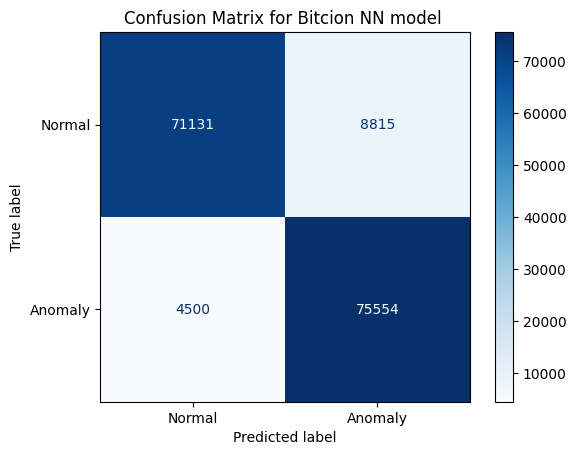

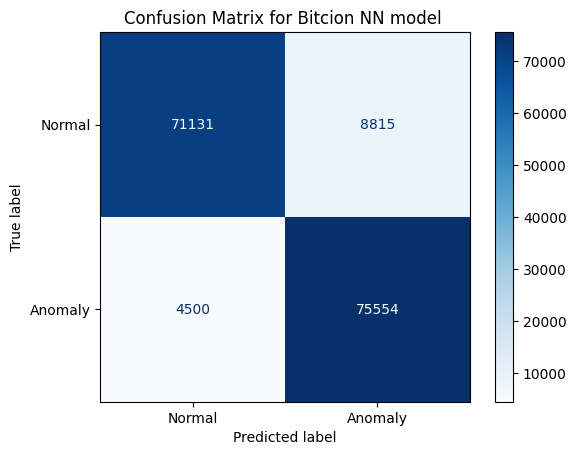

20000/20000 ━━━━━━━━━━━━━━━━━━━━ 20s 986us/step
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


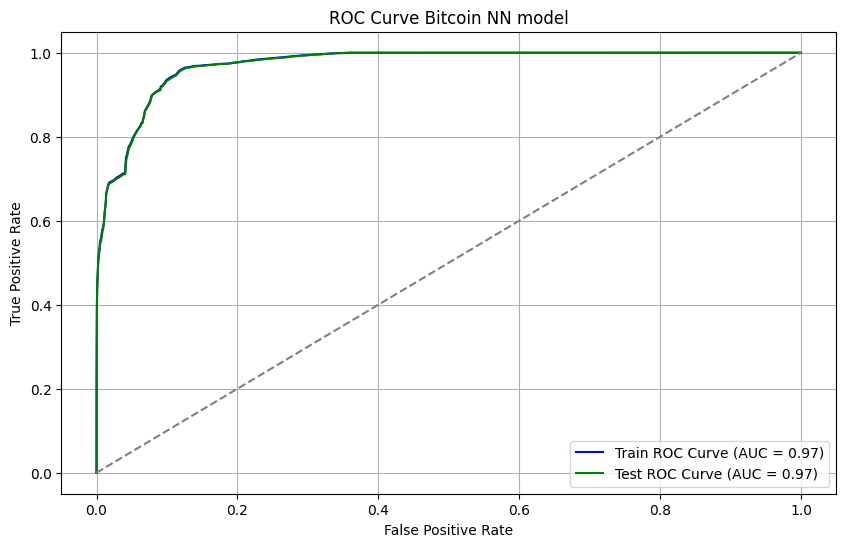

Accuracy: 0.9168
Precision: 0.8955
Recall: 0.9438
F1 Score: 0.9190
ROC AUC: 0.9718


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import necessary libraries
import torch
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle


# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess the Bitcoin dataset
file_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/DG_out.csv'
df = pd.read_csv(file_path, sep=',')
df.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1, inplace=True)

# Apply log transformations and scaling
columns_to_transform = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']
for col in columns_to_transform:
    df[col] = np.log1p(df[col])

scaler = RobustScaler()
df[columns_to_transform] = scaler.fit_transform(df[columns_to_transform])

# Split data into features and labels
X = df.drop('out_and_tx_malicious', axis=1)
y = df['out_and_tx_malicious']

# Display original class distribution
from collections import Counter
print(f"Original class distribution: {Counter(y)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy=1.0, random_state=42, n_jobs=-1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

# Apply RandomUnderSampler to balance the dataset
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_resampled_balanced, y_resampled_balanced = undersampler.fit_resample(X_resampled, y_resampled)
print(f"Class distribution after undersampling: {Counter(y_resampled_balanced)}")

# Select 400,000 samples from each class for training
sample_size = 400000
X_resampled_sampled = pd.concat([
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 0]).sample(sample_size, random_state=42),
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 1]).sample(sample_size, random_state=42)
])
y_resampled_sampled = np.array([0] * sample_size + [1] * sample_size)

# Shuffle the data
X_resampled_sampled, y_resampled_sampled = shuffle(X_resampled_sampled, y_resampled_sampled, random_state=42)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_sampled, y_resampled_sampled, test_size=0.2, random_state=42)

# Build and train the neural network model
nn_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_resampled_sampled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_nn = nn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model
nn_loss, nn_acc = nn_model.evaluate(X_test, y_test)
print(f"NN Accuracy: {nn_acc * 100:.2f}%")

# Save the model
model_path = 'content/drive/MyDrive/BlockChainAnomaly/Data/nn_bitcoin_model.h5'
nn_model.save(model_path)

# Generate predictions
y_pred_prob = nn_model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Bitcion NN model ')
plt.show()

# Get predicted probabilities for both training and test data
y_train_prob = nn_model.predict(X_train)
y_test_prob = nn_model.predict(X_test)

# Calculate ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate ROC curve for test data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for both train and test
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC Curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC Curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Bitcoin NN model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculate precision, recall, F1-score, accuracy, and ROC AUC
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc_test:.4f}")

Save Trained Model

# **Train a Convolutional Neural Network (CNN)**


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import necessary libraries
import torch
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle


# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess the Bitcoin dataset
file_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/DG_out.csv'
df = pd.read_csv(file_path, sep=',')
df.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1, inplace=True)

# Apply log transformations and scaling
columns_to_transform = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']
for col in columns_to_transform:
    df[col] = np.log1p(df[col])

scaler = RobustScaler()
df[columns_to_transform] = scaler.fit_transform(df[columns_to_transform])

# Split data into features and labels
X = df.drop('out_and_tx_malicious', axis=1)
y = df['out_and_tx_malicious']

# Display original class distribution
from collections import Counter
print(f"Original class distribution: {Counter(y)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy=1.0, random_state=42, n_jobs=-1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

# Apply RandomUnderSampler to balance the dataset
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_resampled_balanced, y_resampled_balanced = undersampler.fit_resample(X_resampled, y_resampled)
print(f"Class distribution after undersampling: {Counter(y_resampled_balanced)}")

# Select 400,000 samples from each class for training
sample_size = 400000
X_resampled_sampled = pd.concat([
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 0]).sample(sample_size, random_state=42),
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 1]).sample(sample_size, random_state=42)
])
y_resampled_sampled = np.array([0] * sample_size + [1] * sample_size)

# Shuffle the data
X_resampled_sampled, y_resampled_sampled = shuffle(X_resampled_sampled, y_resampled_sampled, random_state=42)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_sampled, y_resampled_sampled, test_size=0.2, random_state=42)

# Evaluate the model
nn_loss, nn_acc = nn_model.evaluate(X_test, y_test)
print(f"NN Accuracy: {nn_acc * 100:.2f}%")

# Save the model
model_path = 'content/drive/MyDrive/BlockChainAnomaly/Data/nn_bitcoin_model.h5'
nn_model.save(model_path)

# Generate predictions
y_pred_prob = nn_model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Bitcion NN model ')
plt.show()

# Get predicted probabilities for both training and test data
y_train_prob = nn_model.predict(X_train)
y_test_prob = nn_model.predict(X_test)

# Calculate ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate ROC curve for test data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for both train and test
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC Curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC Curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Bitcoin NN model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculate precision, recall, F1-score, accuracy, and ROC AUC
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc_test:.4f}")



Mounted at /content/drive
Original class distribution: Counter({0: 30248026, 1: 108})


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Class distribution after SMOTE: Counter({0: 24198429, 1: 24198429})
Class distribution after undersampling: Counter({0: 24198429, 1: 24198429})
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16000/16000 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.8376 - loss: 0.3668 - val_accuracy: 0.8924 - val_loss: 0.2616
Epoch 2/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.8823 - loss: 0.2833 - val_accuracy: 0.8971 - val_loss: 0.2487
Epoch 3/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.8864 - loss: 0.2717 - val_accuracy: 0.9038 - val_loss: 0.2360
Epoch 4/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.8906 - loss: 0.2619 - val_accuracy: 0.8976 - val_loss: 0.2380
Epoch 5/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.8908 - loss: 0.2611 - val_accuracy: 0.9051 - val_loss: 0.2295
Epoch 6/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.8908 - loss: 0.2582 - val_accuracy: 0.9017 - val_loss: 0.2294
Epoch 7/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.8936 - loss: 0.2560 - val_accuracy: 0.9043 - val_loss: 0.2230
Epoch 8/10
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.8949 - lo

NN Accuracy: 90.61%
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Confusion Matrix:
[[70969  8977]
 [ 6041 74013]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90     79946
           1       0.89      0.92      0.91     80054

    accuracy                           0.91    160000
   macro avg       0.91      0.91      0.91    160000
weighted avg       0.91      0.91      0.91    160000



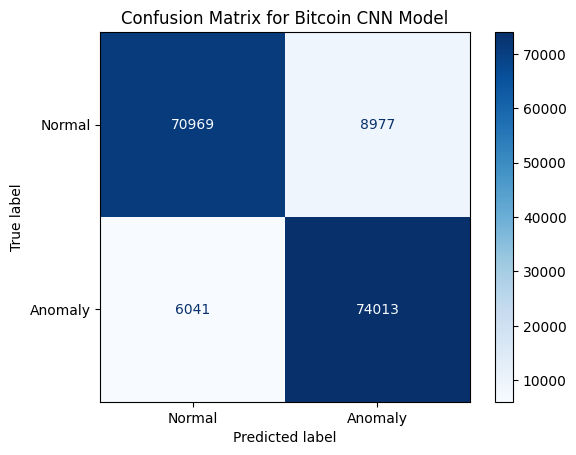

20000/20000 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


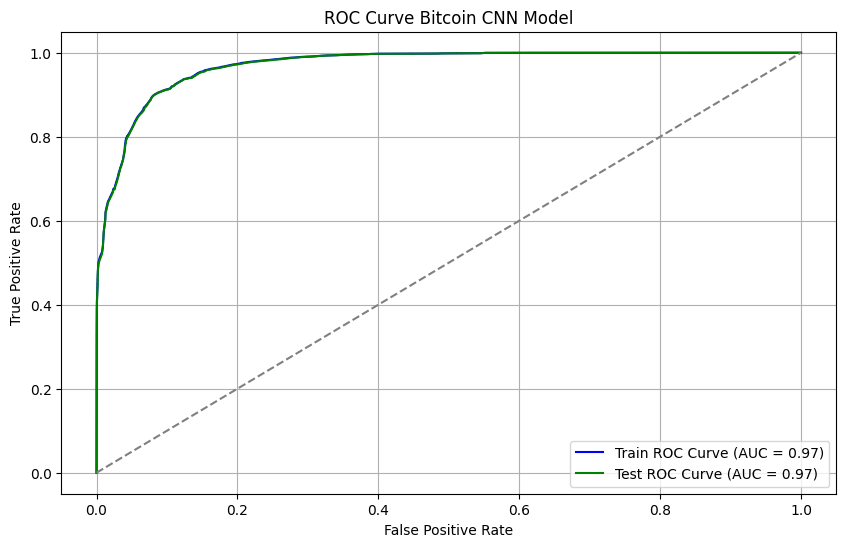

Accuracy: 0.9061
Precision: 0.8918
Recall: 0.9245
F1 Score: 0.9079
ROC AUC: 0.9695


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import necessary libraries
import torch
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.metrics import auc

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess the Bitcoin dataset
file_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/DG_out.csv'
df = pd.read_csv(file_path, sep=',')
df.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1, inplace=True)

# Apply log transformations and scaling
columns_to_transform = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']
for col in columns_to_transform:
    df[col] = np.log1p(df[col])

scaler = RobustScaler()
df[columns_to_transform] = scaler.fit_transform(df[columns_to_transform])

# Split data into features and labels
X = df.drop('out_and_tx_malicious', axis=1)
y = df['out_and_tx_malicious']

# Display original class distribution
from collections import Counter
print(f"Original class distribution: {Counter(y)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy=1.0, random_state=42, n_jobs=-1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

# Apply RandomUnderSampler to balance the dataset
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_resampled_balanced, y_resampled_balanced = undersampler.fit_resample(X_resampled, y_resampled)
print(f"Class distribution after undersampling: {Counter(y_resampled_balanced)}")

# Select 400,000 samples from each class for training
sample_size = 400000
X_resampled_sampled = pd.concat([
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 0]).sample(sample_size, random_state=42),
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 1]).sample(sample_size, random_state=42)
])
y_resampled_sampled = np.array([0] * sample_size + [1] * sample_size)

# Shuffle the data
X_resampled_sampled, y_resampled_sampled = shuffle(X_resampled_sampled, y_resampled_sampled, random_state=42)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_sampled, y_resampled_sampled, test_size=0.2, random_state=42)

# Convert DataFrames to NumPy arrays and reshape
X_train_np = X_train.values  # Convert to NumPy array
X_test_np = X_test.values  # Convert to NumPy array
X_train_reshaped = X_train_np.reshape(-1, X_train_np.shape[1], 1)  # Reshape for Conv1D
X_test_reshaped = X_test_np.reshape(-1, X_test_np.shape[1], 1)  # Reshape for Conv1D

# Build a Conv1D model
cnn_model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),  # Add dropout for regularization
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),  # Add dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn = cnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_reshaped, y_test)
print(f"CNN Accuracy: {cnn_accuracy * 100:.2f}%")

# Save the model
model_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/cnn_bitcoin_model.h5'
cnn_model.save(model_path)

# Generate predictions
y_pred_prob = cnn_model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Bitcoin CNN Model')
plt.show()

# Get predicted probabilities for both training and test data
y_train_prob = cnn_model.predict(X_train_reshaped)
y_test_prob = cnn_model.predict(X_test_reshaped)

# Calculate ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate ROC curve for test data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for both train and test
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC Curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC Curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Bitcoin CNN Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculate precision, recall, F1-score, accuracy, and ROC AUC
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc_test:.4f}")


# **Train a Tabnet model**


In [4]:
pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00


Mounted at /content/drive
Original class distribution: Counter({0: 30248026, 1: 108})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE: Counter({0: 24198429, 1: 24198429})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Class distribution after undersampling: Counter({0: 24198429, 1: 24198429})


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.3059  | train_accuracy: 0.8842  | test_accuracy: 0.88413 |  0:00:58s
epoch 1  | loss: 0.26644 | train_accuracy: 0.88575 | test_accuracy: 0.88525 |  0:01:55s
epoch 2  | loss: 0.25105 | train_accuracy: 0.90227 | test_accuracy: 0.90213 |  0:02:52s
epoch 3  | loss: 0.24237 | train_accuracy: 0.90196 | test_accuracy: 0.90102 |  0:03:49s
Stop training because you reached max_epochs = 4 with best_epoch = 2 and best_test_accuracy = 0.90213


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     79946
           1       0.90      0.91      0.90     80054

    accuracy                           0.90    160000
   macro avg       0.90      0.90      0.90    160000
weighted avg       0.90      0.90      0.90    160000

Confusion Matrix:
[[71812  8134]
 [ 7525 72529]]
Accuracy: 0.9021
Successfully saved model at /content/drive/MyDrive/BlockChainAnomaly/Data/tabnet_bitcoin_model.zip


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full contro

Confusion Matrix:
[[71812  8134]
 [ 7525 72529]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     79946
           1       0.90      0.91      0.90     80054

    accuracy                           0.90    160000
   macro avg       0.90      0.90      0.90    160000
weighted avg       0.90      0.90      0.90    160000



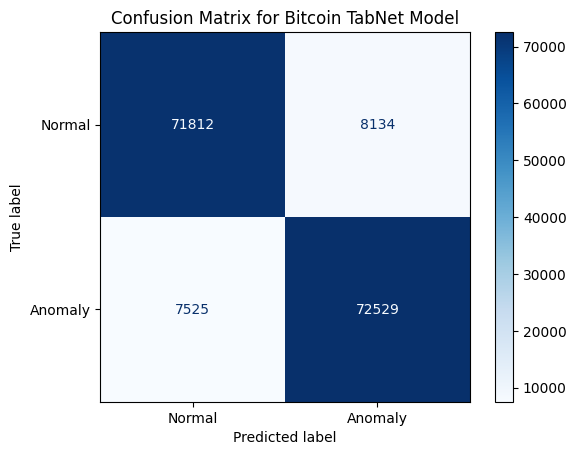

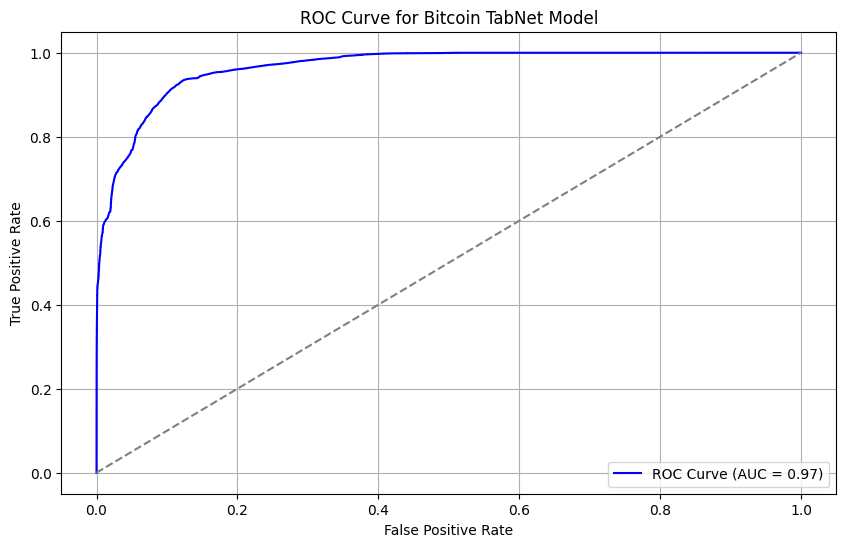

Accuracy: 0.9021
Precision: 0.8992
Recall: 0.9060
F1 Score: 0.9026
ROC AUC: 0.9656


In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import necessary libraries
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.metrics import auc
from collections import Counter

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess the Bitcoin dataset
file_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/DG_out.csv'
df = pd.read_csv(file_path, sep=',')
df.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1, inplace=True)

# Apply log transformations and scaling
columns_to_transform = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']
for col in columns_to_transform:
    df[col] = np.log1p(df[col])

scaler = RobustScaler()
df[columns_to_transform] = scaler.fit_transform(df[columns_to_transform])

# Split data into features and labels
X = df.drop('out_and_tx_malicious', axis=1)
y = df['out_and_tx_malicious']

# Display original class distribution
print(f"Original class distribution: {Counter(y)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

# Apply RandomUnderSampler to balance the dataset
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_resampled_balanced, y_resampled_balanced = undersampler.fit_resample(X_resampled, y_resampled)
print(f"Class distribution after undersampling: {Counter(y_resampled_balanced)}")

# Select 400,000 samples from each class for training
sample_size = 400000
X_resampled_sampled = pd.concat([
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 0]).sample(sample_size, random_state=42),
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 1]).sample(sample_size, random_state=42)
])
y_resampled_sampled = np.array([0] * sample_size + [1] * sample_size)

# Shuffle the data
X_resampled_sampled, y_resampled_sampled = shuffle(X_resampled_sampled, y_resampled_sampled, random_state=42)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_sampled, y_resampled_sampled, test_size=0.2, random_state=42)

# Convert Pandas DataFrames to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train  # Already a NumPy array
y_test_np = y_test  # Already a NumPy array

# Build a TabNet model
tabnet_clf = TabNetClassifier(seed=42)
tabnet_clf.fit(
    X_train_np, y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
    eval_name=['train', 'test'],
    eval_metric=['accuracy'],
    max_epochs=4,
    patience=2,
    batch_size=1024,
    virtual_batch_size=64
)

# Evaluate the model
y_pred = tabnet_clf.predict(X_test_np)
print("Classification Report:")
print(classification_report(y_test_np, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_np, y_pred))
print(f"Accuracy: {accuracy_score(y_test_np, y_pred):.4f}")

# Save the model
model_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/tabnet_bitcoin_model'
tabnet_clf.save_model(model_path)

# Load the model for fine-tuning or inference
tabnet_clf_loaded = TabNetClassifier()
tabnet_clf_loaded.load_model(model_path + ".zip")

# Generate predictions
y_pred_prob = tabnet_clf.predict_proba(X_test_np)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test_np, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test_np, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Bitcoin TabNet Model')
plt.show()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test_np, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Bitcoin TabNet Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculate precision, recall, F1-score, accuracy, and ROC AUC
precision = precision_score(y_test_np, y_pred)
recall = recall_score(y_test_np, y_pred)
f1 = f1_score(y_test_np, y_pred)
accuracy = accuracy_score(y_test_np, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Mounted at /content/drive
Original class distribution: Counter({0: 30248026, 1: 108})
Class distribution after SMOTE: Counter({0: 24198429, 1: 24198429})
Class distribution after undersampling: Counter({0: 24198429, 1: 24198429})


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full contro

Pre-trained TabNet model loaded from: /content/drive/MyDrive/BlockChainAnomaly/Data/tabnet_Ethereum_model.zip
epoch 0  | loss: 0.3059  | train_accuracy: 0.8842  | test_accuracy: 0.88413 |  0:00:55s
epoch 1  | loss: 0.26644 | train_accuracy: 0.88575 | test_accuracy: 0.88525 |  0:01:50s
epoch 2  | loss: 0.25105 | train_accuracy: 0.90227 | test_accuracy: 0.90213 |  0:02:46s
epoch 3  | loss: 0.24237 | train_accuracy: 0.90196 | test_accuracy: 0.90102 |  0:03:42s
epoch 4  | loss: 0.23095 | train_accuracy: 0.91302 | test_accuracy: 0.91254 |  0:04:38s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_test_accuracy = 0.91254


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     79946
           1       0.89      0.95      0.92     80054

    accuracy                           0.91    160000
   macro avg       0.91      0.91      0.91    160000
weighted avg       0.91      0.91      0.91    160000

Confusion Matrix:
[[70225  9721]
 [ 4273 75781]]
Accuracy: 0.9125
Confusion Matrix:
[[70225  9721]
 [ 4273 75781]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     79946
           1       0.89      0.95      0.92     80054

    accuracy                           0.91    160000
   macro avg       0.91      0.91      0.91    160000
weighted avg       0.91      0.91      0.91    160000



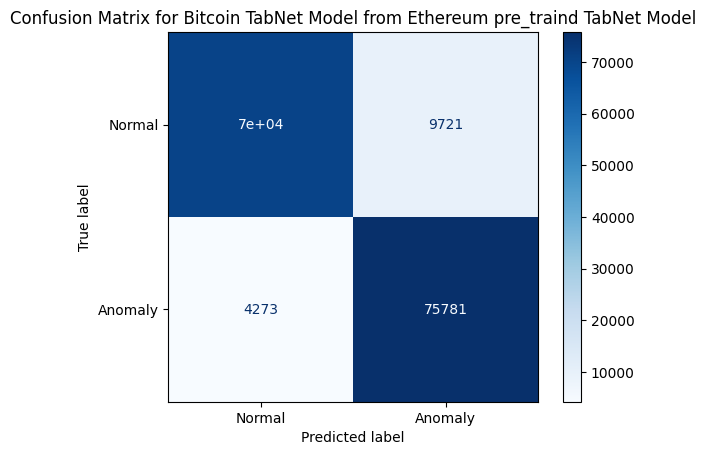

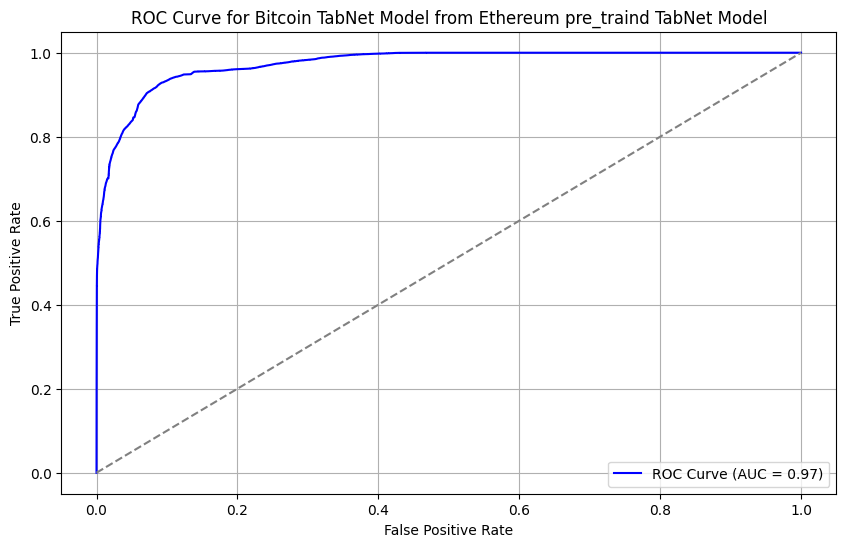

Accuracy: 0.9125
Precision: 0.8863
Recall: 0.9466
F1 Score: 0.9155
ROC AUC: 0.9732


In [ ]:
# Mount Google Drive
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import necessary libraries
import torch
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.metrics import auc
from collections import Counter

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess the Bitcoin dataset
file_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/DG_out.csv'
df = pd.read_csv(file_path, sep=',')
df.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1, inplace=True)

# Apply log transformations and scaling
columns_to_transform = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']
for col in columns_to_transform:
    df[col] = np.log1p(df[col])

scaler = RobustScaler()
df[columns_to_transform] = scaler.fit_transform(df[columns_to_transform])

# Split data into features and labels
X = df.drop('out_and_tx_malicious', axis=1)
y = df['out_and_tx_malicious']

# Display original class distribution
print(f"Original class distribution: {Counter(y)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

# Apply RandomUnderSampler to balance the dataset
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_resampled_balanced, y_resampled_balanced = undersampler.fit_resample(X_resampled, y_resampled)
print(f"Class distribution after undersampling: {Counter(y_resampled_balanced)}")

# Select 400,000 samples from each class for training
sample_size = 400000
X_resampled_sampled = pd.concat([
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 0]).sample(sample_size, random_state=42),
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 1]).sample(sample_size, random_state=42)
])
y_resampled_sampled = np.array([0] * sample_size + [1] * sample_size)

# Shuffle the data
X_resampled_sampled, y_resampled_sampled = shuffle(X_resampled_sampled, y_resampled_sampled, random_state=42)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_sampled, y_resampled_sampled, test_size=0.2, random_state=42)

# Convert Pandas DataFrames to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train  # Already a NumPy array
y_test_np = y_test  # Already a NumPy array

# Load the pre-trained Ethereum TabNet model
model_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/tabnet_Ethereum_model.zip'
tabnet_model = TabNetClassifier()
tabnet_model.load_model(model_path)
print(f"Pre-trained TabNet model loaded from: {model_path}")

# Fine-tune the model on the Bitcoin dataset
tabnet_model.fit(
    X_train_np, y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
    eval_name=['train', 'test'],
    eval_metric=['accuracy'],
    max_epochs=5,
    patience=2,
    batch_size=1024,
    virtual_batch_size=64
)

# Evaluate the model
y_pred = tabnet_model.predict(X_test_np)
print("Classification Report:")
print(classification_report(y_test_np, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_np, y_pred))
print(f"Accuracy: {accuracy_score(y_test_np, y_pred):.4f}")

# Generate predictions
y_pred_prob = tabnet_model.predict_proba(X_test_np)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test_np, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test_np, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Bitcoin TabNet Model from Ethereum pre_traind TabNet Model')
plt.show()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test_np, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Bitcoin TabNet Model from Ethereum pre_traind TabNet Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculate precision, recall, F1-score, accuracy, and ROC AUC
precision = precision_score(y_test_np, y_pred)
recall = recall_score(y_test_np, y_pred)
f1 = f1_score(y_test_np, y_pred)
accuracy = accuracy_score(y_test_np, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# **Transfer Learining from Wallet Dataset Tabnet model**

Mounted at /content/drive
Original class distribution: Counter({0: 30248026, 1: 108})
Class distribution after SMOTE: Counter({0: 24198429, 1: 24198429})
Class distribution after undersampling: Counter({0: 24198429, 1: 24198429})


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full contro

Pre-trained TabNet model loaded from: /content/drive/MyDrive/BlockChainAnomaly/Data/tabnet_wallet_model.zip
epoch 0  | loss: 0.30573 | train_accuracy: 0.85197 | test_accuracy: 0.85134 |  0:01:01s
epoch 1  | loss: 0.27469 | train_accuracy: 0.8325  | test_accuracy: 0.83158 |  0:02:03s
epoch 2  | loss: 0.26001 | train_accuracy: 0.69615 | test_accuracy: 0.69558 |  0:03:04s

Early stopping occurred at epoch 2 with best_epoch = 0 and best_test_accuracy = 0.85134


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.75      0.83     79946
           1       0.79      0.95      0.86     80054

    accuracy                           0.85    160000
   macro avg       0.87      0.85      0.85    160000
weighted avg       0.87      0.85      0.85    160000

Confusion Matrix:
[[60019 19927]
 [ 3858 76196]]
Accuracy: 0.8513
Confusion Matrix:
[[60019 19927]
 [ 3858 76196]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.75      0.83     79946
           1       0.79      0.95      0.86     80054

    accuracy                           0.85    160000
   macro avg       0.87      0.85      0.85    160000
weighted avg       0.87      0.85      0.85    160000



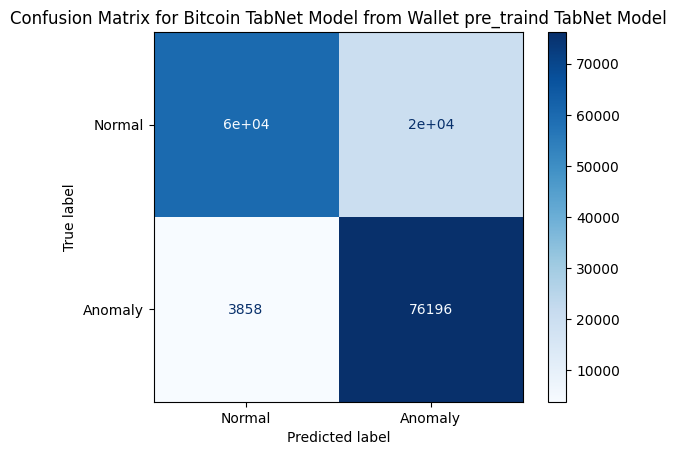

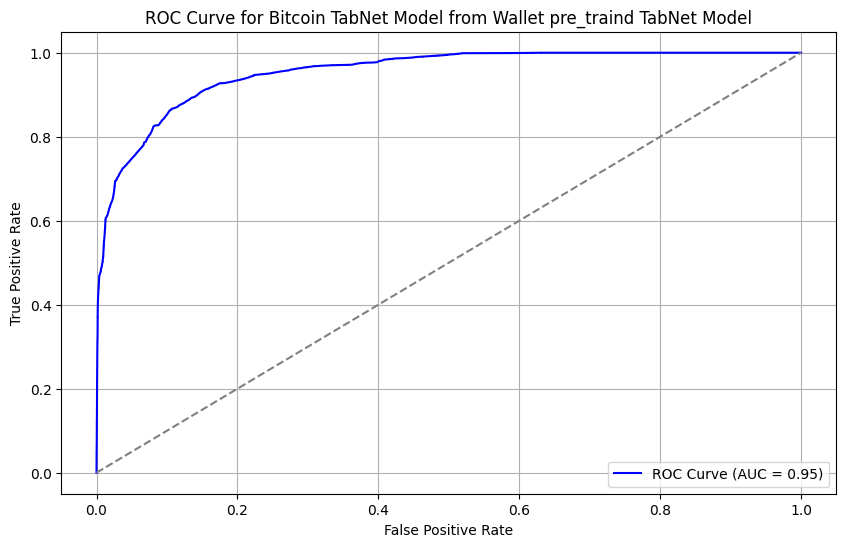

Accuracy: 0.8513
Precision: 0.7927
Recall: 0.9518
F1 Score: 0.8650
ROC AUC: 0.9531


In [ ]:
# Mount Google Drive
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import necessary libraries
import torch
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.metrics import auc
from collections import Counter

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess the Bitcoin dataset
file_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/DG_out.csv'
df = pd.read_csv(file_path, sep=',')
df.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1, inplace=True)

# Apply log transformations and scaling
columns_to_transform = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']
for col in columns_to_transform:
    df[col] = np.log1p(df[col])

scaler = RobustScaler()
df[columns_to_transform] = scaler.fit_transform(df[columns_to_transform])

# Split data into features and labels
X = df.drop('out_and_tx_malicious', axis=1)
y = df['out_and_tx_malicious']

# Display original class distribution
print(f"Original class distribution: {Counter(y)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

# Apply RandomUnderSampler to balance the dataset
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_resampled_balanced, y_resampled_balanced = undersampler.fit_resample(X_resampled, y_resampled)
print(f"Class distribution after undersampling: {Counter(y_resampled_balanced)}")

# Select 400,000 samples from each class for training
sample_size = 400000
X_resampled_sampled = pd.concat([
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 0]).sample(sample_size, random_state=42),
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 1]).sample(sample_size, random_state=42)
])
y_resampled_sampled = np.array([0] * sample_size + [1] * sample_size)

# Shuffle the data
X_resampled_sampled, y_resampled_sampled = shuffle(X_resampled_sampled, y_resampled_sampled, random_state=42)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_sampled, y_resampled_sampled, test_size=0.2, random_state=42)

# Convert Pandas DataFrames to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train  # Already a NumPy array
y_test_np = y_test  # Already a NumPy array

# Load the pre-trained Ethereum TabNet model
model_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/tabnet_wallet_model.zip'
tabnet_model = TabNetClassifier()
tabnet_model.load_model(model_path)
print(f"Pre-trained TabNet model loaded from: {model_path}")

# Fine-tune the model on the Bitcoin dataset
tabnet_model.fit(
    X_train_np, y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
    eval_name=['train', 'test'],
    eval_metric=['accuracy'],
    max_epochs=5,
    patience=2,
    batch_size=1024,
    virtual_batch_size=64
)

# Evaluate the model
y_pred = tabnet_model.predict(X_test_np)
print("Classification Report:")
print(classification_report(y_test_np, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_np, y_pred))
print(f"Accuracy: {accuracy_score(y_test_np, y_pred):.4f}")

# Generate predictions
y_pred_prob = tabnet_model.predict_proba(X_test_np)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_test_np, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test_np, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Bitcoin TabNet Model from Wallet pre_traind TabNet Model')
plt.show()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test_np, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Bitcoin TabNet Model from Wallet pre_traind TabNet Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculate precision, recall, F1-score, accuracy, and ROC AUC
precision = precision_score(y_test_np, y_pred)
recall = recall_score(y_test_np, y_pred)
f1 = f1_score(y_test_np, y_pred)
accuracy = accuracy_score(y_test_np, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# **Transfer Learining from Wallet Dataset CNN model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Original class distribution: Counter({0: 30248026, 1: 108})
Class distribution after SMOTE: Counter({0: 24198429, 1: 24198429})
Class distribution after undersampling: Counter({0: 24198429, 1: 24198429})


Skipping layer due to mismatch: Layer conv1d_4 weight shape (3, 1, 64) is not compatible with provided weight shape (3, 1, 32).
Skipping layer due to mismatch: Layer dense_26 weight shape (128, 32) is not compatible with provided weight shape (64, 1).
Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7713 - loss: 0.4634 - val_accuracy: 0.8502 - val_loss: 0.3556
Epoch 2/4
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8383 - loss: 0.3653 - val_accuracy: 0.8571 - val_loss: 0.3293
Epoch 3/4
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8548 - loss: 0.3407 - val_accuracy: 0.8734 - val_loss: 0.3050
Epoch 4/4
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8639 - loss: 0.3231 - val_accuracy: 0.8788 - val_loss: 0.2879
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8787 - loss: 0.2903
Fine-tuned CNN Accuracy: 87.82%
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


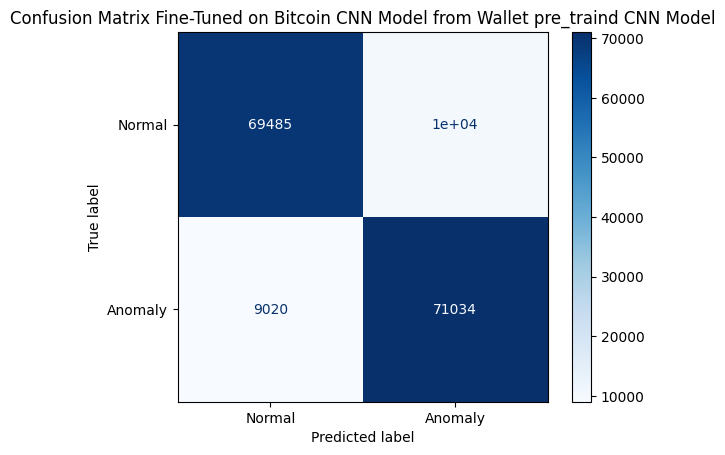

Accuracy: 0.8782
Precision: 0.8716
Recall: 0.8873
F1 Score: 0.8794
ROC AUC: 0.9469
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step


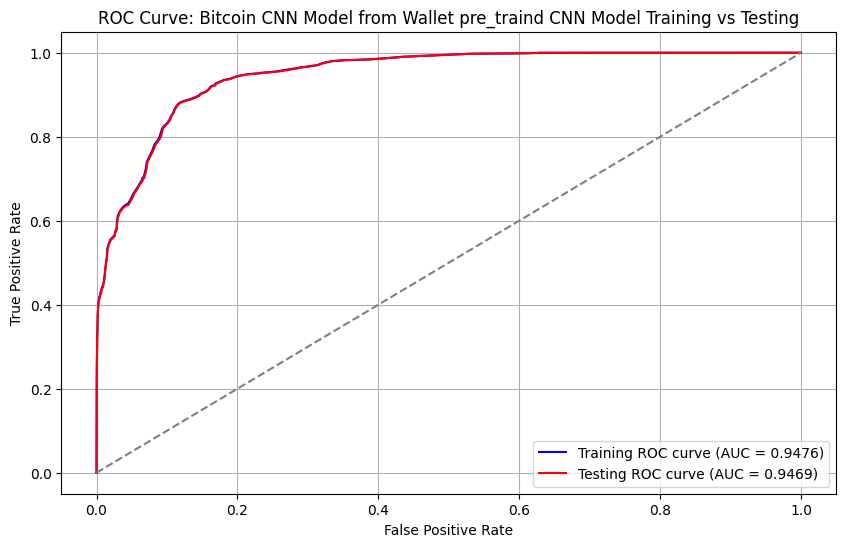

In [ ]:
# Mount Google Drive
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import necessary libraries
import torch
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.metrics import auc
from collections import Counter

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess the Bitcoin dataset
file_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/DG_out.csv'
df = pd.read_csv(file_path, sep=',')
df.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1, inplace=True)

# Apply log transformations and scaling
columns_to_transform = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']
for col in columns_to_transform:
    df[col] = np.log1p(df[col])

scaler = RobustScaler()
df[columns_to_transform] = scaler.fit_transform(df[columns_to_transform])

# Split data into features and labels
X = df.drop('out_and_tx_malicious', axis=1)
y = df['out_and_tx_malicious']

# Display original class distribution
print(f"Original class distribution: {Counter(y)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

# Apply RandomUnderSampler to balance the dataset
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_resampled_balanced, y_resampled_balanced = undersampler.fit_resample(X_resampled, y_resampled)
print(f"Class distribution after undersampling: {Counter(y_resampled_balanced)}")

# Select 400,000 samples from each class for training
sample_size = 400000
X_resampled_sampled = pd.concat([
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 0]).sample(sample_size, random_state=42),
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 1]).sample(sample_size, random_state=42)
])
y_resampled_sampled = np.array([0] * sample_size + [1] * sample_size)

# Shuffle the data
X_resampled_sampled, y_resampled_sampled = shuffle(X_resampled_sampled, y_resampled_sampled, random_state=42)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_sampled, y_resampled_sampled, test_size=0.2, random_state=42)

# Convert Pandas DataFrames to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train  # Already a NumPy array
y_test_np = y_test  # Already a NumPy array

# Load the pre-trained model
pretrained_model = models.load_model('/content/drive/MyDrive/BlockChainAnomaly/Data/cnn_wallet_model.h5')
# Convert DataFrames to NumPy arrays and reshape
X_train_np = X_train.values  # Convert to NumPy array
X_test_np = X_test.values  # Convert to NumPy array
X_train_reshaped = X_train_np.reshape(-1, X_train_np.shape[1], 1)  # Reshape for Conv1D
X_test_reshaped = X_test_np.reshape(-1, X_test_np.shape[1], 1)  # Reshape for Conv1D

# Build the new model
# Build the new model with Dropout
new_cnn_model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),  # Add Dropout after the first pooling layer
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),  # Add Dropout after the first Dense layer
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

for layer, pretrained_layer in zip(new_cnn_model.layers, pretrained_model.layers):
    try:
        if isinstance(layer, layers.Conv1D) or isinstance(layer, layers.Dense):
            layer.set_weights(pretrained_layer.get_weights())
            layer.trainable = False  # Freeze the layers to retain learned features
    except ValueError as e:
        print(f"Skipping layer due to mismatch: {e}")


# Compile the new model
new_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the new model on the new dataset
history_new_cnn = new_cnn_model.fit(X_train_reshaped, y_train, epochs=4, batch_size=1024, validation_split=0.2)

# Unfreeze layers (optional, for fine-tuning)
for layer in new_cnn_model.layers:
    layer.trainable = True
# Evaluate the model
cnn_loss, cnn_acc = new_cnn_model.evaluate(X_test_reshaped, y_test)
print(f"Fine-tuned CNN Accuracy: {cnn_acc * 100:.2f}%")


## Generate predictions
y_pred_prob = new_cnn_model.predict(X_test_reshaped).ravel()  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Fine-Tuned on Bitcoin CNN Model from Wallet pre_traind CNN Model')
plt.show()

# Calculate precision, recall, F1-score, accuracy, and ROC AUC
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Use probabilities for ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Compute ROC curve and ROC AUC for training data
y_train_pred_prob = new_cnn_model.predict(X_train_reshaped).ravel()
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
roc_auc_train = roc_auc_score(y_train, y_train_pred_prob)

# Compute ROC curve and ROC AUC for testing data
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob)
roc_auc_test = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {roc_auc_train:.4f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Testing ROC curve (AUC = {roc_auc_test:.4f})', color='red')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line

# Labels and legend
plt.title('ROC Curve: Bitcoin CNN Model from Wallet pre_traind CNN Model Training vs Testing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




# **Transfer Learining from Ethereum Dataset CNN model**

Mounted at /content/drive
Original class distribution: Counter({0: 30248026, 1: 108})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE: Counter({0: 24198429, 1: 24198429})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Class distribution after undersampling: Counter({0: 24198429, 1: 24198429})


Skipping layer due to mismatch: Layer conv1d weight shape (3, 1, 64) is not compatible with provided weight shape (3, 1, 32).
Skipping layer due to mismatch: Layer dense_9 weight shape (128, 32) is not compatible with provided weight shape (64, 1).
Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7746 - loss: 0.4619 - val_accuracy: 0.8379 - val_loss: 0.3587
Epoch 2/4
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8315 - loss: 0.3662 - val_accuracy: 0.8573 - val_loss: 0.3374
Epoch 3/4
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8449 - loss: 0.3473 - val_accuracy: 0.8667 - val_loss: 0.3162
Epoch 4/4
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8563 - loss: 0.3284 - val_accuracy: 0.8792 - val_loss: 0.2981
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8784 - loss: 0.3000
Fine-tuned CNN Accuracy: 87.80%
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


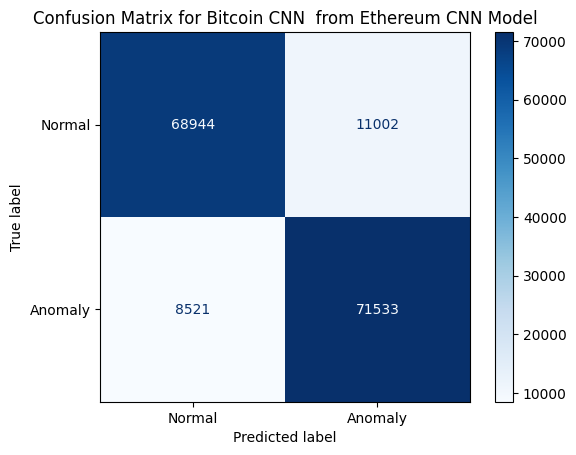

Accuracy: 0.8780
Precision: 0.8667
Recall: 0.8936
F1 Score: 0.8799
ROC AUC: 0.9427
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step


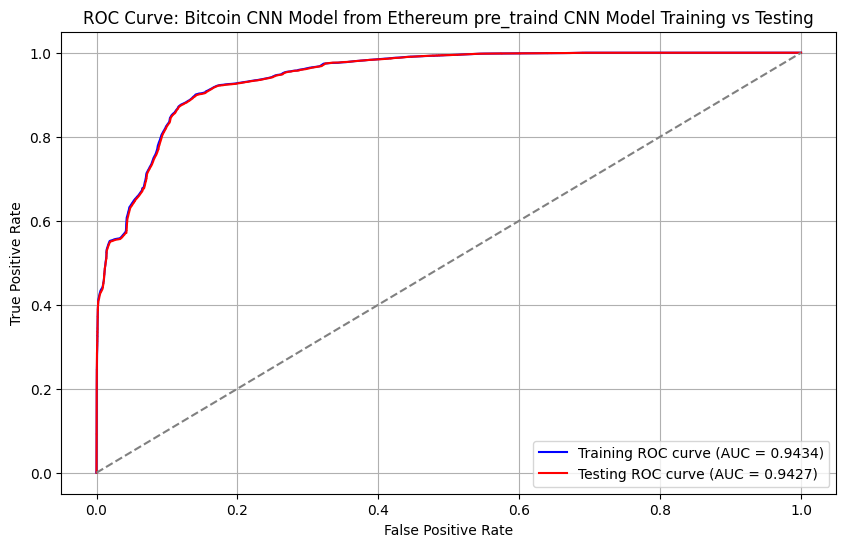

In [9]:
# Mount Google Drive
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import necessary libraries
import torch
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.metrics import auc
from collections import Counter

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess the Bitcoin dataset
file_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/DG_out.csv'
df = pd.read_csv(file_path, sep=',')
df.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1, inplace=True)

# Apply log transformations and scaling
columns_to_transform = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']
for col in columns_to_transform:
    df[col] = np.log1p(df[col])

scaler = RobustScaler()
df[columns_to_transform] = scaler.fit_transform(df[columns_to_transform])

# Split data into features and labels
X = df.drop('out_and_tx_malicious', axis=1)
y = df['out_and_tx_malicious']

# Display original class distribution
print(f"Original class distribution: {Counter(y)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

# Apply RandomUnderSampler to balance the dataset
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_resampled_balanced, y_resampled_balanced = undersampler.fit_resample(X_resampled, y_resampled)
print(f"Class distribution after undersampling: {Counter(y_resampled_balanced)}")

# Select 400,000 samples from each class for training
sample_size = 400000
X_resampled_sampled = pd.concat([
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 0]).sample(sample_size, random_state=42),
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 1]).sample(sample_size, random_state=42)
])
y_resampled_sampled = np.array([0] * sample_size + [1] * sample_size)

# Shuffle the data
X_resampled_sampled, y_resampled_sampled = shuffle(X_resampled_sampled, y_resampled_sampled, random_state=42)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_sampled, y_resampled_sampled, test_size=0.2, random_state=42)

# Convert Pandas DataFrames to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train  # Already a NumPy array
y_test_np = y_test  # Already a NumPy array

# Load the pre-trained model
pretrained_model = models.load_model('/content/drive/MyDrive/BlockChainAnomaly/Data/cnn_Ethereum_model.h5')
# Convert DataFrames to NumPy arrays and reshape
X_train_np = X_train.values  # Convert to NumPy array
X_test_np = X_test.values  # Convert to NumPy array
X_train_reshaped = X_train_np.reshape(-1, X_train_np.shape[1], 1)  # Reshape for Conv1D
X_test_reshaped = X_test_np.reshape(-1, X_test_np.shape[1], 1)  # Reshape for Conv1D

# Build the new model
# Build the new model with Dropout
new_cnn_model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),  # Add Dropout after the first pooling layer
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),  # Add Dropout after the first Dense layer
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

for layer, pretrained_layer in zip(new_cnn_model.layers, pretrained_model.layers):
    try:
        if isinstance(layer, layers.Conv1D) or isinstance(layer, layers.Dense):
            layer.set_weights(pretrained_layer.get_weights())
            layer.trainable = False  # Freeze the layers to retain learned features
    except ValueError as e:
        print(f"Skipping layer due to mismatch: {e}")


# Compile the new model
new_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the new model on the new dataset
history_new_cnn = new_cnn_model.fit(X_train_reshaped, y_train, epochs=4, batch_size=1024, validation_split=0.2)

# Unfreeze layers (optional, for fine-tuning)
for layer in new_cnn_model.layers:
    layer.trainable = True
# Evaluate the model
cnn_loss, cnn_acc = new_cnn_model.evaluate(X_test_reshaped, y_test)
print(f"Fine-tuned CNN Accuracy: {cnn_acc * 100:.2f}%")


## Generate predictions
y_pred_prob = new_cnn_model.predict(X_test_reshaped).ravel()  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Bitcoin CNN  from Ethereum CNN Model')
plt.show()

# Calculate precision, recall, F1-score, accuracy, and ROC AUC
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Use probabilities for ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Compute ROC curve and ROC AUC for training data
y_train_pred_prob = new_cnn_model.predict(X_train_reshaped).ravel()
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
roc_auc_train = roc_auc_score(y_train, y_train_pred_prob)

# Compute ROC curve and ROC AUC for testing data
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob)
roc_auc_test = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {roc_auc_train:.4f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Testing ROC curve (AUC = {roc_auc_test:.4f})', color='red')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line

# Labels and legend
plt.title('ROC Curve: Bitcoin CNN Model from Ethereum pre_traind CNN Model Training vs Testing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




# **Transfer Learining from Wallet Dataset NN model**

Mounted at /content/drive
Original class distribution: Counter({0: 30248026, 1: 108})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE: Counter({0: 24198429, 1: 24198429})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Class distribution after undersampling: Counter({0: 24198429, 1: 24198429})


Pre-trained Wallet model loaded from: /content/drive/MyDrive/BlockChainAnomaly/Data/nn_wallet_model.h5
Skipping layer due to mismatch: Layer dense_3 weight shape (7, 128) is not compatible with provided weight shape (56, 128).
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16000/16000 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.8235 - loss: 0.3793 - val_accuracy: 0.8755 - val_loss: 0.2832
Epoch 2/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.8683 - loss: 0.3057 - val_accuracy: 0.8819 - val_loss: 0.2697
Epoch 3/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.8732 - loss: 0.2955 - val_accuracy: 0.8841 - val_loss: 0.2680
Epoch 4/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.8761 - loss: 0.2914 - val_accuracy: 0.8869 - val_loss: 0.2654
Epoch 5/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.8766 - loss: 0.2886 - val_accuracy: 0.8892 - val_loss: 0.2565
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8883 - loss: 0.2584


Fine-Tuned Bitcoin NN Accuracy: 88.78%
Fine-tuned Bitcoin model saved to: /content/drive/MyDrive/BlockChainAnomaly/Data/nn_bitcoin_fine_tuned_model.h5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


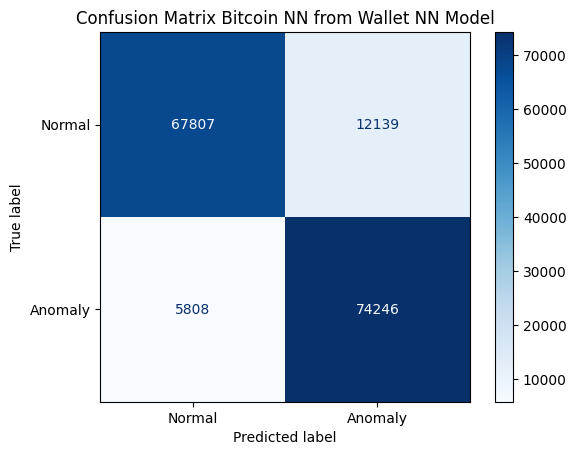

Accuracy: 0.8878
Precision: 0.8595
Recall: 0.9274
F1 Score: 0.8922
ROC AUC: 0.9575


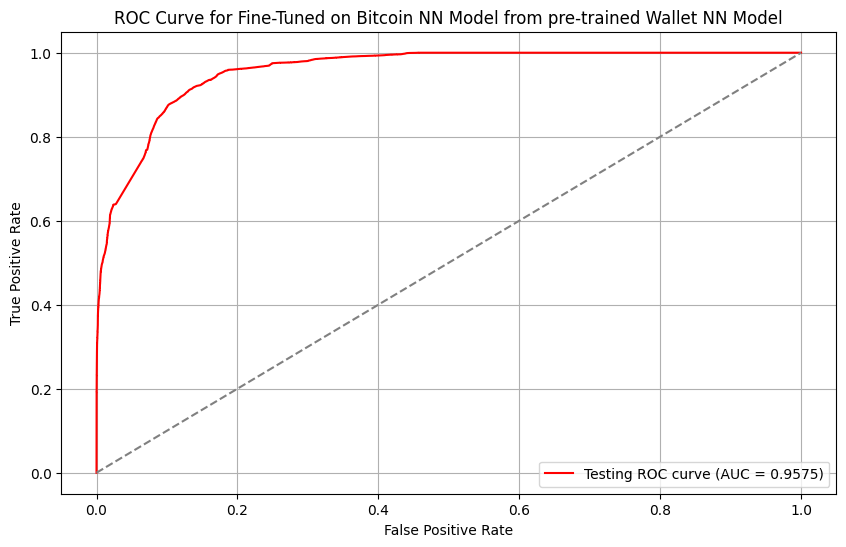

In [2]:
# Mount Google Drive
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import necessary libraries
import torch
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.metrics import auc
from collections import Counter
from tensorflow.keras import models
from tensorflow.keras import layers

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess the Bitcoin dataset
file_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/DG_out.csv'
df = pd.read_csv(file_path, sep=',')
df.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1, inplace=True)

# Apply log transformations and scaling
columns_to_transform = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']
for col in columns_to_transform:
    df[col] = np.log1p(df[col])

scaler = RobustScaler()
df[columns_to_transform] = scaler.fit_transform(df[columns_to_transform])

# Split data into features and labels
X = df.drop('out_and_tx_malicious', axis=1)
y = df['out_and_tx_malicious']

# Display original class distribution
print(f"Original class distribution: {Counter(y)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

# Apply RandomUnderSampler to balance the dataset
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_resampled_balanced, y_resampled_balanced = undersampler.fit_resample(X_resampled, y_resampled)
print(f"Class distribution after undersampling: {Counter(y_resampled_balanced)}")

# Select 400,000 samples from each class for training
sample_size = 400000
X_resampled_sampled = pd.concat([
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 0]).sample(sample_size, random_state=42),
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 1]).sample(sample_size, random_state=42)
])
y_resampled_sampled = np.array([0] * sample_size + [1] * sample_size)

# Shuffle the data
X_resampled_sampled, y_resampled_sampled = shuffle(X_resampled_sampled, y_resampled_sampled, random_state=42)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_sampled, y_resampled_sampled, test_size=0.2, random_state=42)

# Convert Pandas DataFrames to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train  # Already a NumPy array
y_test_np = y_test  # Already a NumPy array

# Load the pre-trained Wallet NN model
nn_model2_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/nn_wallet_model.h5'
nn_model2 = models.load_model(nn_model2_path)
print(f"Pre-trained Wallet model loaded from: {nn_model2_path}")

# Define the Bitcoin NN model
nn_model23 = models.Sequential([
 layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Transfer weights from the Wallet model to the Bitcoin model
for layer, nn_model2_layer in zip(nn_model23.layers, nn_model2.layers):
    try:
        if isinstance(layer, layers.Dense):
            layer.set_weights(nn_model2_layer.get_weights())
            layer.trainable = False  # Freeze pre-trained layers
    except ValueError as e:
        print(f"Skipping layer due to mismatch: {e}")


# Compile the Bitcoin model
nn_model23.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the Bitcoin NN model
history_bitcoin = nn_model23.fit(
    X_train, y_train, epochs=5, batch_size=32, validation_split=0.2
)

# Unfreeze layers for further fine-tuning
for layer in nn_model23.layers:
    layer.trainable = True

# Evaluate the fine-tuned model
bitcoin_loss, bitcoin_acc = nn_model23.evaluate(X_test, y_test)
print(f"Fine-Tuned Bitcoin NN Accuracy: {bitcoin_acc * 100:.2f}%")

# Save the fine-tuned Bitcoin model
nn_model23_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/nn_bitcoin_fine_tuned_model.h5'
nn_model23.save(nn_model23_path)
print(f"Fine-tuned Bitcoin model saved to: {nn_model23_path}")

# Generate predictions
y_pred_prob = nn_model23.predict(X_test).ravel()  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Bitcoin NN from Wallet NN Model')
plt.show()

# Calculate precision, recall, F1-score, accuracy, and ROC AUC
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Use probabilities for ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Compute ROC curve and ROC AUC for testing data
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob)
roc_auc_test = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Testing ROC curve (AUC = {roc_auc_test:.4f})', color='red')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line

# Labels and legend
plt.title('ROC Curve for Fine-Tuned on Bitcoin NN Model from pre-trained Wallet NN Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# **Transfer Learining from Etheruem Dataset NN model**

Mounted at /content/drive
Original class distribution: Counter({0: 30248026, 1: 108})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE: Counter({0: 24198429, 1: 24198429})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Class distribution after undersampling: Counter({0: 24198429, 1: 24198429})


Pre-trained Wallet model loaded from: /content/drive/MyDrive/BlockChainAnomaly/Data/nn_Ethereum_model.h5
Skipping layer due to mismatch: Layer dense_6 weight shape (7, 128) is not compatible with provided weight shape (25, 128).
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16000/16000 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.8153 - loss: 0.4801 - val_accuracy: 0.8844 - val_loss: 0.2703
Epoch 2/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.8788 - loss: 0.2882 - val_accuracy: 0.8902 - val_loss: 0.2580
Epoch 3/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.8849 - loss: 0.2779 - val_accuracy: 0.8945 - val_loss: 0.2502
Epoch 4/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.8873 - loss: 0.2716 - val_accuracy: 0.8972 - val_loss: 0.2476
Epoch 5/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.8909 - loss: 0.2673 - val_accuracy: 0.9029 - val_loss: 0.2485
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9019 - loss: 0.2500


Fine-Tuned Bitcoin NN Accuracy: 90.18%
Fine-tuned Bitcoin model saved to: /content/drive/MyDrive/BlockChainAnomaly/Data/nn_bitcoin_fine_tuned_model.h5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


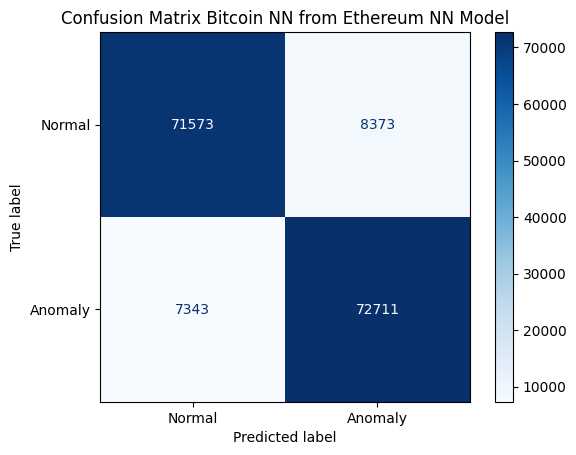

Accuracy: 0.9018
Precision: 0.8967
Recall: 0.9083
F1 Score: 0.9025
ROC AUC: 0.9625


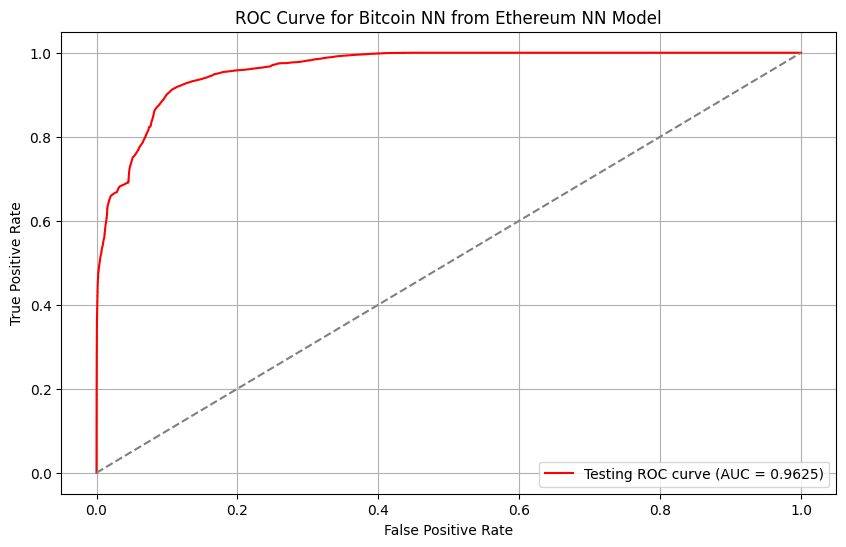

In [3]:
# Mount Google Drive
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import necessary libraries
import torch
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.metrics import auc
from collections import Counter
from tensorflow.keras import models
from tensorflow.keras import layers

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess the Bitcoin dataset
file_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/DG_out.csv'
df = pd.read_csv(file_path, sep=',')
df.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1, inplace=True)

# Apply log transformations and scaling
columns_to_transform = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']
for col in columns_to_transform:
    df[col] = np.log1p(df[col])

scaler = RobustScaler()
df[columns_to_transform] = scaler.fit_transform(df[columns_to_transform])

# Split data into features and labels
X = df.drop('out_and_tx_malicious', axis=1)
y = df['out_and_tx_malicious']

# Display original class distribution
print(f"Original class distribution: {Counter(y)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(f"Class distribution after SMOTE: {Counter(y_resampled)}")

# Apply RandomUnderSampler to balance the dataset
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_resampled_balanced, y_resampled_balanced = undersampler.fit_resample(X_resampled, y_resampled)
print(f"Class distribution after undersampling: {Counter(y_resampled_balanced)}")

# Select 400,000 samples from each class for training
sample_size = 400000
X_resampled_sampled = pd.concat([
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 0]).sample(sample_size, random_state=42),
    pd.DataFrame(X_resampled_balanced[y_resampled_balanced == 1]).sample(sample_size, random_state=42)
])
y_resampled_sampled = np.array([0] * sample_size + [1] * sample_size)

# Shuffle the data
X_resampled_sampled, y_resampled_sampled = shuffle(X_resampled_sampled, y_resampled_sampled, random_state=42)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_sampled, y_resampled_sampled, test_size=0.2, random_state=42)

# Convert Pandas DataFrames to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train  # Already a NumPy array
y_test_np = y_test  # Already a NumPy array

# Load the pre-trained Wallet NN model
nn_model22_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/nn_Ethereum_model.h5'
nn_model22 = models.load_model(nn_model22_path)
print(f"Pre-trained Wallet model loaded from: {nn_model22_path}")

# Define the Bitcoin NN model
nn_model3 = models.Sequential([
 layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Transfer weights from the Wallet model to the Bitcoin model
for layer, nn_model22_layer in zip(nn_model3.layers, nn_model22.layers):
    try:
        if isinstance(layer, layers.Dense):
            layer.set_weights(nn_model22_layer.get_weights())
            layer.trainable = False  # Freeze pre-trained layers
    except ValueError as e:
        print(f"Skipping layer due to mismatch: {e}")


# Compile the Bitcoin model
nn_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the Bitcoin NN model
history_bitcoin = nn_model3.fit(
    X_train, y_train, epochs=5, batch_size=32, validation_split=0.2
)

# Unfreeze layers for further fine-tuning
for layer in nn_model2.layers:
    layer.trainable = True

# Evaluate the fine-tuned model
bitcoin_loss, bitcoin_acc = nn_model3.evaluate(X_test, y_test)
print(f"Fine-Tuned Bitcoin NN Accuracy: {bitcoin_acc * 100:.2f}%")

# Save the fine-tuned Bitcoin model
nn_model3_path = '/content/drive/MyDrive/BlockChainAnomaly/Data/nn_bitcoin_fine_tuned_model.h5'
nn_model3.save(nn_model3_path)
print(f"Fine-tuned Bitcoin model saved to: {nn_model3_path}")

# Generate predictions
y_pred_prob = nn_model3.predict(X_test).ravel()  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Bitcoin NN from Ethereum NN Model')
plt.show()

# Calculate precision, recall, F1-score, accuracy, and ROC AUC
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Use probabilities for ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Compute ROC curve and ROC AUC for testing data
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob)
roc_auc_test = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Testing ROC curve (AUC = {roc_auc_test:.4f})', color='red')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line

# Labels and legend
plt.title('ROC Curve for Bitcoin NN from Ethereum NN Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
